In [52]:
import numpy as np 
import student
import riarit
from matplotlib import pyplot as plt
from R_table import R_table
import baselines

%load_ext autoreload
%autoreload 2

# Model definition

In [83]:
ex_type=np.array([[0.7,0.4,0,0,0,0.5],
    [0.7,0.6,0.3,0,0,0.5],
    [0.7,0.7,0.6,0,0,0.5],
    [1,0.7,0.6,0.5,0.3,0.7],
    [1,0.9,0.7,0.7,0.5,0.7],
    [1,1,1,1,1,1]])

price_presentation=np.array([[0.8,1,1,1,1,0.2],
    [1,1,1,1,1,0.6],
    [0.9,1,1,1,1,1]])

cents_notation=np.array([[0.8,1,1,1,1,1],
    [0.9,1,1,1,1,1]])

money_type=np.array([[1,1,1,0.9,0.9,1],
    [0.1,1,1,1,1,1]]) # 1 for not relevent value (will be ignored in the R_table)

#### Parameters

In [94]:
        
T = 150 # number of rounds
n_c = 6 # KnowMoney IntSum IntDec DecSum DecDec Memory 

gamma = 0.05

alpha_c_hat = 0.1

R_table_model=R_table([ex_type,price_presentation,cents_notation,money_type])
initKC = np.zeros(n_c)
n_p=R_table_model.n_p
learning_rates = np.random.uniform(low =0.05,high =0.05,size=n_c)


success_prob=0.8 # probability of sucess when KC=R_table
alpha=np.log(success_prob/(1-success_prob))
beta = 15

beta_w = 1 ## coefficient of the previous value w_a
eta_w = 0.2 ## learning rate for w_a
 

## Check Riarit behavior, which arm is preferred ?

In [85]:
def gen_w_a_iter(current_student,method):
    if method == "Random":
        reward_list,_,activity_list,_,c_true,w_a_history = \
            riarit.Exp3(current_student,T,R_table_model,alpha_c_hat,1,compute_regret=False)

    elif method == 'Riarit':
        reward_list,_,activity_list,_,c_true,w_a_history = \
            riarit.Exp3(current_student,T,R_table_model,alpha_c_hat,gamma,compute_regret=False)

    else:
        return
    
    return w_a_history,activity_list


In [102]:
to_test=["Random","Riarit"]
w_a_mean={method : None for method in to_test}
n_itr=50
T=1000
activities={method:np.zeros((n_itr,T,n_p)) for method in to_test}
for i in range(n_itr):
    print("Iteration : {}/{}".format(i+1,n_itr),end='\r')
    for method in to_test:
        current_student=student.Student(R_table_model,initKC,learning_rates,alpha,beta,lambdas=None)
        w_a_history,activities[method][i,:,:]=gen_w_a_iter(current_student,method)
        if w_a_mean[method] is None:
            w_a_mean[method]=[w_a_history[j]/n_itr for j in range(n_p)]
        else:
            for j in range(n_p):
                w_a_mean[method][j]=w_a_mean[method][j]+w_a_history[j]/n_itr


### Plot mean w_a and activity most often given at each time

************************************************************************
Random
************************************************************************


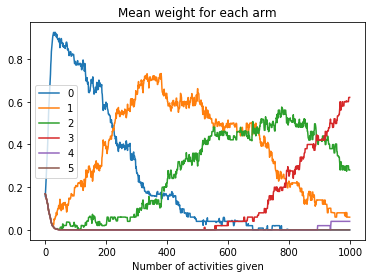

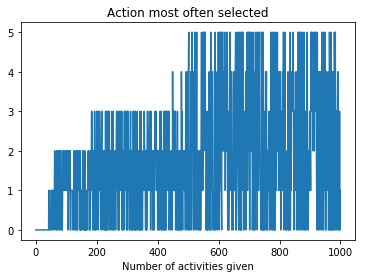

************************************************************************
Riarit
************************************************************************


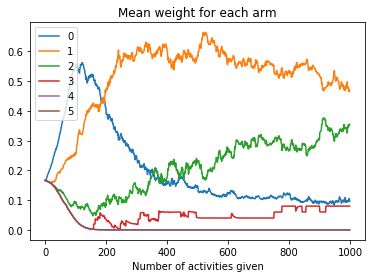

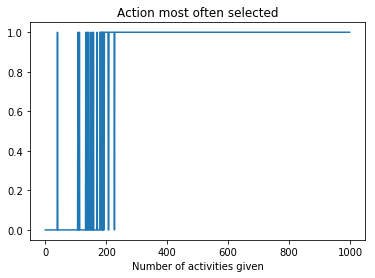

In [103]:
param=0
n_a=R_table_model.n_a[param]
res={method : np.zeros((n_a,T)) for method in to_test}

for method in to_test:
    print("************************************************************************")
    print(method)
    print("************************************************************************")

    plt.figure()
    plt.plot(w_a_mean[method][0])
    plt.legend(["{}".format(i) for i in range(R_table_model.n_a[0])])
    plt.title("Mean weight for each arm")
    plt.xlabel("Number of activities given")
    plt.show()
    
    for i in range(n_a): # all possible values of parameter 
        res[method][i,:]=np.sum(activities[method][:,:,param]==i,axis=0)

    plt.figure()
    plt.title("Action most often selected")
    plt.plot(np.argmax(res[method],axis=0))
    plt.xlabel("Number of activities given")

    plt.show()

Better exploration for Random as expected

# Average evolution of KC for one student for 3 methods

In [104]:
# %% Plot the evolution of competences  for one student 
gamma=0.1
initKC=0.*np.ones(n_c)
def gen_progresses_iter(current_student,method,T,alpha_c_hat,gamma):
    """
    Generate one iteration of giving T activity to one student with method
    returns the KC of the student function of time

    """
    if method == "Predefined sequence":
        activity_list,c_true,_ = \
            baselines.predefined_sequence(current_student,R_table_model,T)

    elif method == "Random":
        reward_list,_,activity_list,_,c_true,_ = \
            riarit.Exp3(current_student,T,R_table_model,alpha_c_hat,1)

    elif method == 'Riarit':
        reward_list,_,activity_list,_,c_true,_ = \
            riarit.Exp3(current_student,T,R_table_model,alpha_c_hat,gamma)

    else:
        return
    
    return c_true
 

In [107]:
n_itr=50
T=500
methods=["Predefined sequence","Random","Riarit"]
true_KC = {method : None for method in methods}
activities = {method : None for method in methods}
for i in range(n_itr):
    print("Iteration : {}/{}".format(i+1,n_itr),end='\r')
    for method in methods:            
        current_student=student.Student(R_table_model,initKC,learning_rates,alpha,beta,lambdas=None)
        KC_iter=gen_progresses_iter(current_student,method,T,alpha_c_hat,gamma)
        if true_KC[method] is None:
            true_KC[method]=KC_iter/n_itr
        else:
            true_KC[method]=true_KC[method]+KC_iter/n_itr

KeyboardInterrupt: 

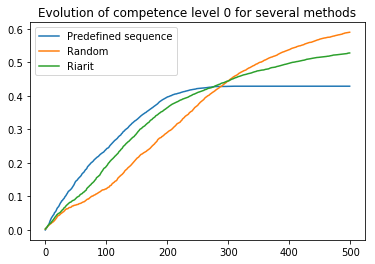

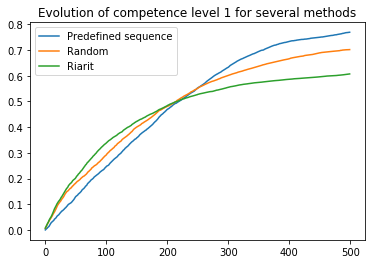

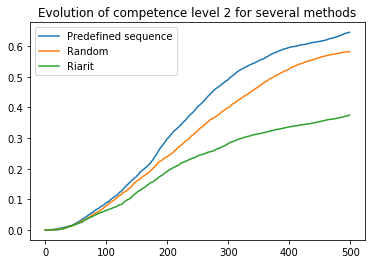

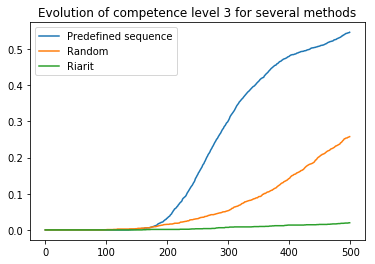

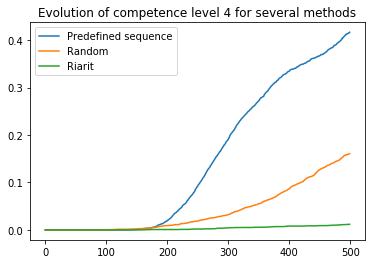

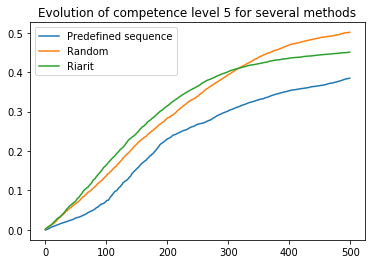

In [99]:
for c in range(n_c):
    plt.figure()
    for method in methods:
        plt.plot(true_KC[method][c],label=method)
        
    plt.legend()
    plt.title("Evolution of competence level {} for several methods".format(c))
    plt.show()

Riarit is not better than Random: **ERROR**

# Classrooms test

#### Students definition

In [120]:
pstudents=[]
nb_students=50
T = 200 # number of rounds
n_c = 6 # KnowMoney IntSum IntDec DecSum DecDec Memory 
R_table_model=R_table([ex_type,price_presentation,cents_notation,money_type])
n_p=R_table_model.n_p

###########################################################################
# These parameters can vary depending on the student but not for now 
success_prob=0.8 # probability of sucess when KC=R_table
alpha=np.log(success_prob/(1-success_prob))
beta = 15
###########################################################################


for i in range(nb_students):
    ######## PARAMETERS THAT VARY FOR EACH STUDENT #################
    initKC = np.random.uniform(low=0,high=0.5,size=n_c)
    learning_rates = np.random.uniform(low =0.02,high =0.1,size=n_c)
    ################################################################
    
    pstudents.append(student.Student(R_table_model,initKC,learning_rates,alpha,beta,lambdas=None))
    

In [116]:
# Riarit parameters :
gamma=0.05
n_itr=50

# Iterations for each student and each methods
final_KC={method : [np.zeros((n_c,))]*nb_students for method in methods}
for iteration in range(n_itr):
    print(iteration)
    for i,c_student in enumerate(pstudents):
        for method in methods:
            final_KC[method][i]+=gen_progresses_iter(c_student,method,T,alpha_c_hat,gamma)[:,-1]/n_itr
            c_student.reset()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [117]:
final_KC


{'Predefined sequence': [array([ 44.56460132,  49.95565592,  49.93814393,  49.92762149,
          49.90191095,  49.46366577]),
  array([ 44.56460132,  49.95565592,  49.93814393,  49.92762149,
          49.90191095,  49.46366577]),
  array([ 44.56460132,  49.95565592,  49.93814393,  49.92762149,
          49.90191095,  49.46366577]),
  array([ 44.56460132,  49.95565592,  49.93814393,  49.92762149,
          49.90191095,  49.46366577]),
  array([ 44.56460132,  49.95565592,  49.93814393,  49.92762149,
          49.90191095,  49.46366577]),
  array([ 44.56460132,  49.95565592,  49.93814393,  49.92762149,
          49.90191095,  49.46366577]),
  array([ 44.56460132,  49.95565592,  49.93814393,  49.92762149,
          49.90191095,  49.46366577]),
  array([ 44.56460132,  49.95565592,  49.93814393,  49.92762149,
          49.90191095,  49.46366577]),
  array([ 44.56460132,  49.95565592,  49.93814393,  49.92762149,
          49.90191095,  49.46366577]),
  array([ 44.56460132,  49.95565592,  49.

In [121]:
gen_progresses_iter(c_student,method,T,alpha_c_hat,gamma)[:,-1]

array([ 0.9,  1. ,  1. ,  1. ,  1. ,  1. ])